Imports

In [1]:
# General

from scipy import stats
import scipy
from skimage.filters import threshold_otsu, rank
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from skimage.morphology import binary_erosion, binary_dilation, disk, square
import pandas as pd
import sys
from scipy import ndimage
from datacube import helpers
from datacube.utils import geometry
from matplotlib.patches import Rectangle

# PCA

# import sklearn
sys.path.append('/g/data/u46/users/sc0554/cult_area/LCCS/')
from xarray_pca import xarray_pca

# Image Seg

from skimage import io
from skimage.segmentation import quickshift
import sklearn.feature_extraction.image
import sklearn.cluster
from skimage.segmentation import mark_boundaries, slic, watershed
from skimage.util import img_as_float
from skimage.color import rgb2gray
from skimage.filters import sobel

# TMAD PCA

In [52]:
# Open dataset
# tmad = xr.open_dataset('/g/data/u46/users/sc0554/cult_area/townsville_2y_input/mad-20150101-20161231_15_-22.nc')
# tmad = xr.open_dataset('/g/data/u46/users/sc0554/cult_area/townsville_1y_input/mad-20160101-20161231_15_-22.nc')
# tmad = xr.open_dataset('/g/data/u46/users/sc0554/cult_area/Barmah-Millewa_2y_input/mad-20150101-20161231_11_-40.nc')
# tmad = xr.open_dataset('/g/data/u46/users/sc0554/cult_area/Snowy_2y_input/mad-20150101-20161231_14_-41.nc')
tmad= xr.open_dataset('/g/data/u46/users/bt2744/work/data/mad-annual/prod/ls8/ls8_ternary_mad-20150101-20151231_11_-40.nc')


# Subset here

tmad_sub = tmad.isel(x=slice(500,2000), y=slice(500, 2000))

In [53]:
tmad

<xarray.Dataset>
Dimensions:  (time: 1, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 ... -4e+06 -4e+06 -4e+06
  * x        (x) float64 1.1e+06 1.1e+06 1.1e+06 ... 1.2e+06 1.2e+06 1.2e+06
Data variables:
    crs      int32 ...
    sdev     (time, y, x) float32 ...
    edev     (time, y, x) float32 ...
    bcdev    (time, y, x) float32 ...
    dataset  (time) |S484240 ...
Attributes:
    date_created:           2018-12-27T04:23:42.066092
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.6.1...
    geospatial_bounds:      POLYGON ((144.128374150833 -35.2304209533476,144....
    geospatial_bounds_crs:  EPSG:4326
    geospatial_lat_min:     -36.1267770885557
    geospatial_lat_max:     -35.141340045739746
    geospatial_lat_units:   degrees_north
    geospatial_lon_min:     144.12837415083308
    geospatial_lon_max:     145.33805252515648
 

In [54]:
edev = tmad.edev.data.squeeze()
sdev = tmad.sdev.data.squeeze()
bcdev = tmad.bcdev.data.squeeze()
tmad_pca = xarray_pca(tmad, ['sdev', 'edev', 'bcdev'])

In [55]:
tmad_np = tmad_pca.data
print(np.min(tmad_np), np.max(tmad_np))

0.009360432624816895 0.2639968991279602


In [67]:
# Calculate the optimum threshold for max NDVI
# thresh = threshold_otsu(tmad_np)
thresh = 0.06

# Filter by the threshold
tmad_filt = tmad_np > thresh
# tmad_filt = np.where(tmad_np > 0.055, 1, 0)

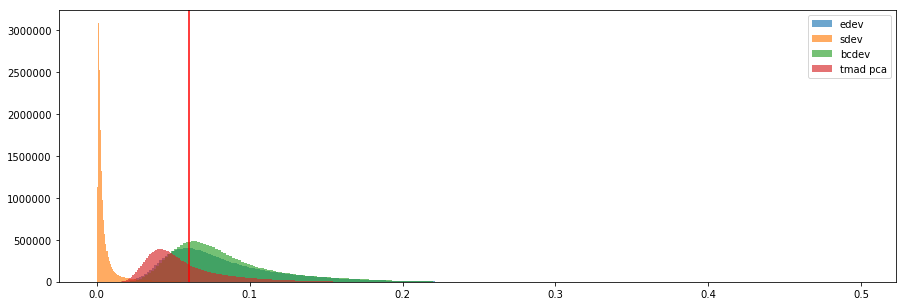

In [68]:
# labels= ["edev","sdev", "bcdev", "tmad_np"]

fig, ax = plt.subplots(ncols=1, figsize=(15,5))
ax.hist(edev.ravel(), bins=256, label='edev', alpha=0.65)
ax.hist(sdev.ravel(), bins=256, label='sdev', alpha=0.65)
ax.hist(bcdev.ravel(), bins=256, label='bcdev', alpha=0.65)
ax.hist(tmad_np.ravel(), bins=256, label='tmad pca', alpha=0.65)
ax.axvline(thresh, color='r')

ax.legend(prop={'size': 10})

Text(0.5, 1.0, 'eDEV')

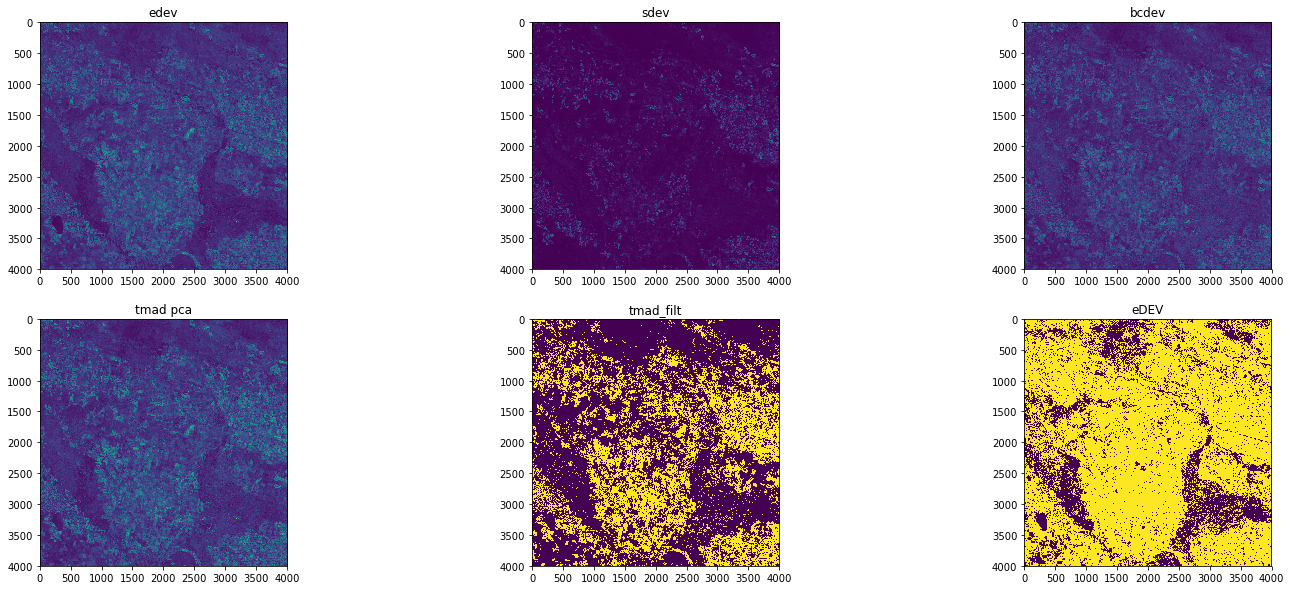

In [69]:
fig, ax = plt.subplots(2,3, figsize=(25,10))
ax[0][0].imshow(edev)
ax[0][0].set_title('edev')
ax[0][1].imshow(sdev)
ax[0][1].set_title('sdev')
ax[0][2].imshow(bcdev)
ax[0][2].set_title('bcdev')
ax[1][0].imshow(tmad_np)
ax[1][0].set_title('tmad pca')
ax[1][1].imshow(tmad_filt)
ax[1][1].set_title('tmad_filt')
ax[1][2].imshow(edev > .055)
ax[1][2].set_title('eDEV')

# Vegetation Image segmentation

In [70]:
# read in max ndvi data and convert to Numpy array

# img_path = '/g/data/u46/users/sc0554/cult_area/townsville_1y_input/woody_15_-22.nc'
# img_path = '/g/data/u46/users/sc0554/cult_area/Barmah-Millewa_2y_input/woody_11_-40.nc'
img_path = '/g/data/u46/users/sc0554/cult_area/LCCS/FC_barmah.nc'
# img_path = '/g/data/u46/users/sc0554/cult_area/Snowy_2y_input/woody_14_-41.nc'
# img = io.imread(image)
# img = xr.open_rasterio(img_path)
img = xr.open_dataset(img_path)
# img_v = np.squeeze(img['veg'].values).astype(float)
img_v = img['PV_PC_90'].values.squeeze().astype(float) # Fractional cover


In [91]:
thresh = 50
no_seg = img_v > thresh

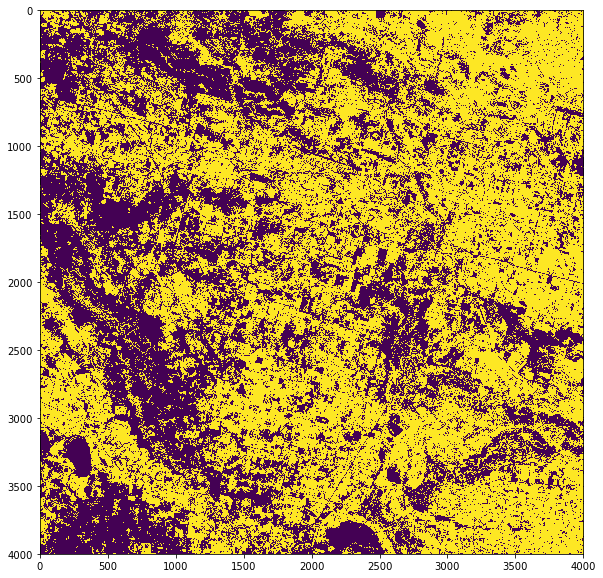

In [92]:
fig, ax = plt.subplots(ncols=1, figsize=(20,10))
ax.imshow(no_seg)

In [9]:
# Segment the  max ndvi numpy array

# %%time
# Note: convert2lab=False allows the use of multiband images
seg_qs = quickshift(img_v, kernel_size=5, convert2lab=False, max_dist=500, ratio=0.5)
print("Quickshift number of segments: %d" % len(np.unique(seg_qs)))

Quickshift number of segments: 10861


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


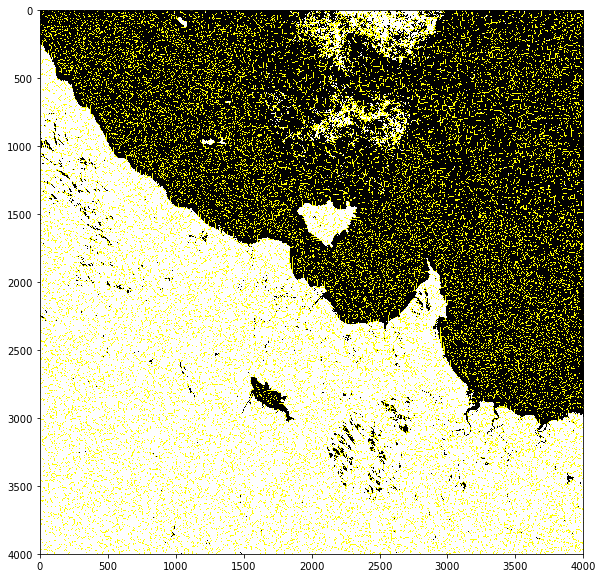

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(mark_boundaries(img_v, seg_qs))

In [11]:
# Calculate the median max ndvi value for each segment

seg_med = scipy.ndimage.median(input=img_v, labels=seg_qs, index=seg_qs)

In [12]:
# Calculate the optimum threshold for max NDVI
# thresh = threshold_otsu(seg_med)
# thresh = 0.55
thresh = 70

print(thresh)
# Filter by the threshold
thresh_seg_med = seg_med > thresh

# seg_median_filt = np.where(seg_median_filt > 0.4, 1, 0)
# seg_median_filt = np.where(seg_median_filt > 0.55, 1, 0) # tville

70


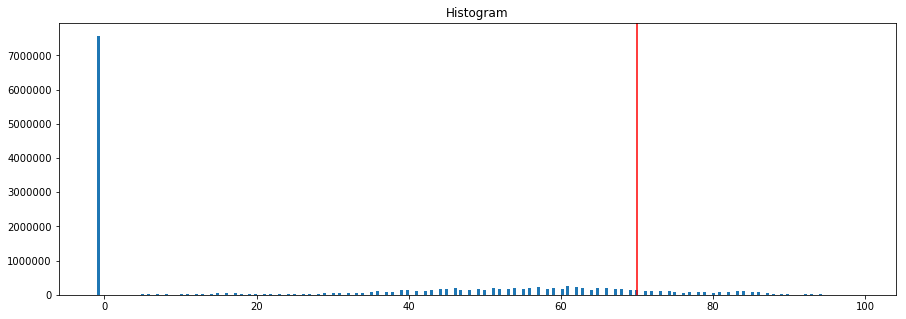

In [13]:
fig, ax = plt.subplots(ncols=1, figsize=(15,5))
ax.hist(seg_med.ravel(), bins=256)
ax.set_title('Histogram')
ax.axvline(thresh, color='r')

In [14]:
# Create an empty numpy array with the same shape as the input
img_fill = np.ones((img_v.shape))
# Assign the segment size values to each value belonging to that 
seg_size = scipy.ndimage.sum(input=img_fill, labels=seg_qs, index=seg_qs)
print(np.unique(seg_size))

[   30.    33.    38. ...  9886. 10262. 10374.]


In [15]:
# Filter by segment size
# thresh_seg_med_filt = np.where((seg_size > 500) & (seg_size < 5000), thresh_seg_med, 0) # previously 2000 for small size
thresh_seg_med_filt = np.where((seg_size > 500) & (seg_size < 19000), thresh_seg_med, 0) # Tville

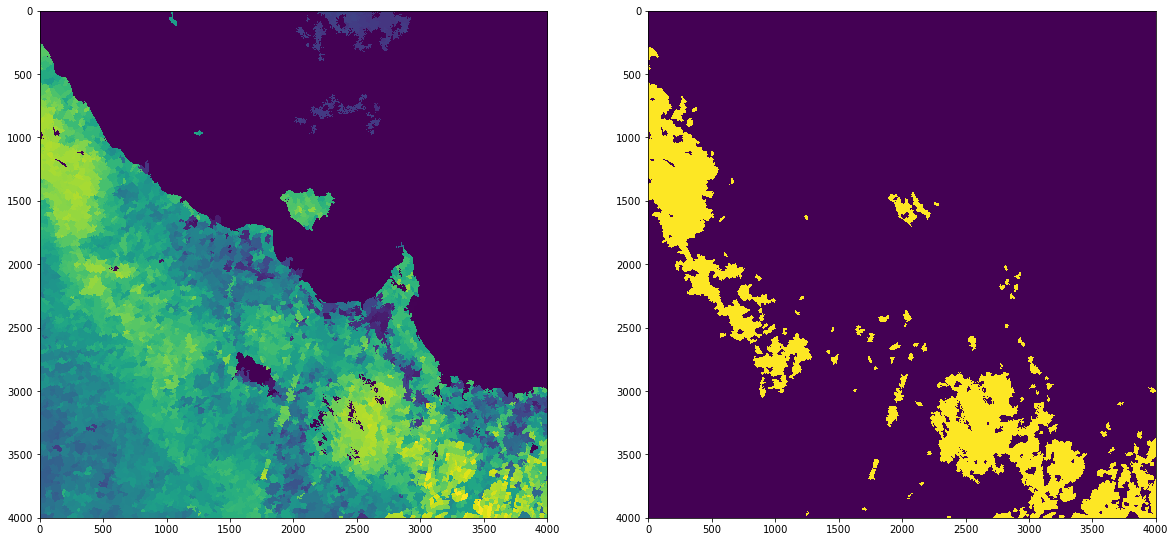

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].imshow(seg_med)
ax[1].imshow(thresh_seg_med_filt)

## Segmentation and MAD combination

In [93]:
cult_area = np.logical_and(tmad_filt, no_seg)

In [94]:
cult_area_filt = ndimage.median_filter(cult_area, 4)
cult_area_filt = np.where(cult_area_filt == True, 1, 0).astype(float)
ero_cult = binary_erosion(cult_area, square(2))
dil_cult = binary_dilation(ero_cult, square(2))

# Plot processing stages

Text(0.5, 1.0, 'Dilation\n Pixels: 4055349')

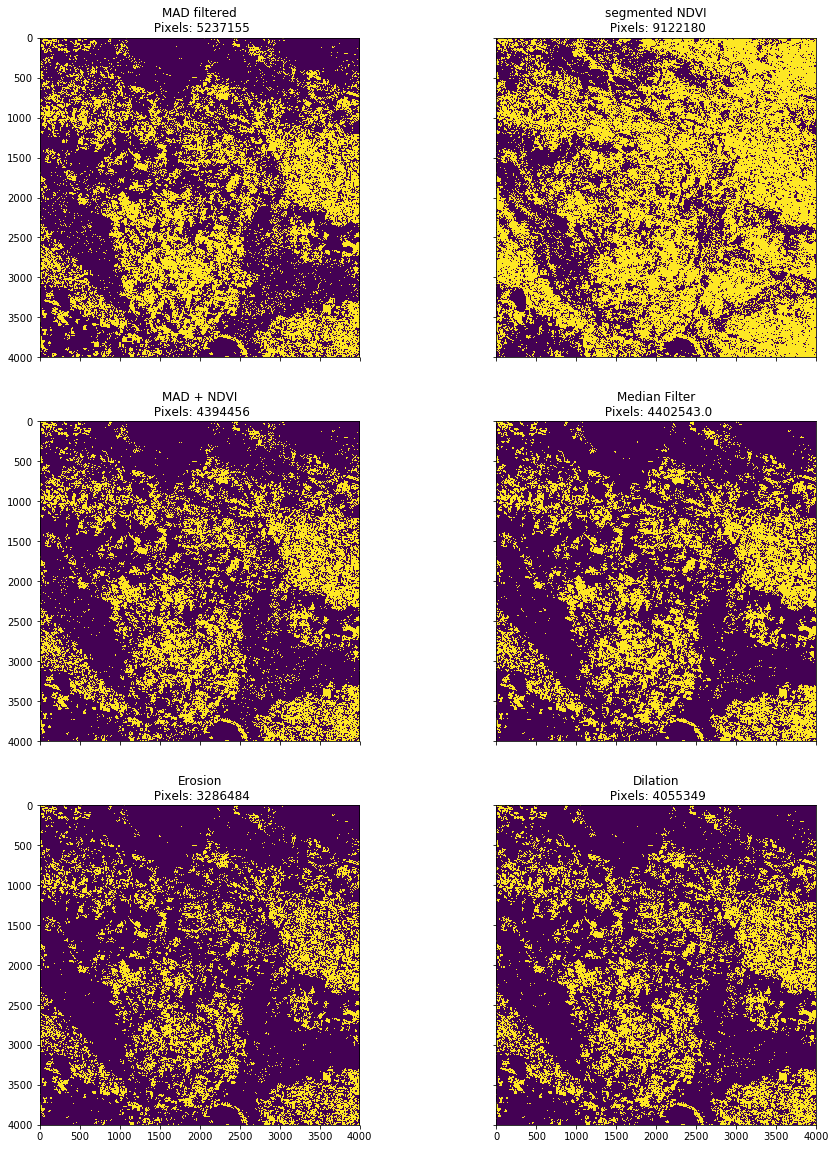

In [95]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15,20), sharex=True, sharey=True)
ax[0][0].imshow(tmad_filt)
ax[0][0].set_title('MAD filtered' + '\n Pixels: ' + str(np.sum(tmad_filt)))
ax[0][1].imshow(no_seg)
ax[0][1].set_title('segmented NDVI' + '\n Pixels: ' + str(np.sum(no_seg)))
ax[1][0].imshow(cult_area)
ax[1][0].set_title('MAD + NDVI' + '\n Pixels: ' + str(np.sum(cult_area)))
ax[1][1].imshow(cult_area_filt)
ax[1][1].set_title('Median Filter' + '\n Pixels: ' + str(np.sum(cult_area_filt)))
ax[2][0].imshow(ero_cult)
ax[2][0].set_title('Erosion' + '\n Pixels: ' + str(np.sum(ero_cult)))
ax[2][1].imshow(dil_cult)
ax[2][1].set_title('Dilation' + '\n Pixels: ' + str(np.sum(dil_cult)))
# fig.savefig('cultareaprocess')

# Convert back to xarray

In [85]:
# meta_d = img_s.squeeze().drop('band') tville
# meta_d = img.squeeze().drop('time')
meta_d = tmad.squeeze().drop('time')
# meta_d = img_s.squeeze().drop('time')

In [86]:
# out = xr.DataArray(cult_area_filt, coords=meta_d.coords, dims=meta_d.dims)
out = xr.Dataset({'cultfrac':(meta_d.dims,cult_area_filt)}, coords=meta_d.coords, attrs=meta_d.attrs)
# out.attrs = meta_d.attrs
out.attrs['crs']=geometry.CRS(meta_d.crs.attrs['crs_wkt'])

In [87]:
helpers.write_geotiff('barmah_frac_cult.tif', out)

In [ ]:
out.to_netcdf('caf_pca_snowy2.nc')